In [1]:
from TrafficLight import PeriodicTrafficLight, AdaptiveTrafficLight, TrafficLightMirror
import Model1
import Model2
from ModelEvaluation import Evaluator, MultiEvaluator
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import pickle

*Periodic traffic lights*

In [2]:
light_ew = PeriodicTrafficLight()
light_ew.initialize(period=30, time_delay=0, green_ratio=0.8)

light_ns = TrafficLightMirror()
light_ns.initialize(traffic_light=light_ew)

*Adaptive traffic lights*

In [3]:
light_ew = AdaptiveTrafficLight()
light_ew.initialize(sensor_depth=8, rule=1)

light_ns = TrafficLightMirror()
light_ns.initialize(traffic_light=light_ew)

In [4]:
network = Model1.IntersectionNetworkSimulator()
network.initialize(grid_dimensions=(1,1))
network.set_queue_rate_parameters(grid_ind=(0,0), avg_departure_time=0.5, avg_arrival_time_n=4, avg_arrival_time_e=3, avg_arrival_time_s=4, avg_arrival_time_w=3)
network.set_traffic_lights(grid_ind=(0,0), traffic_light_ns=light_ns, traffic_light_ew=light_ew)
network.set_observable_intersections(grid_inds=network.grid_inds)

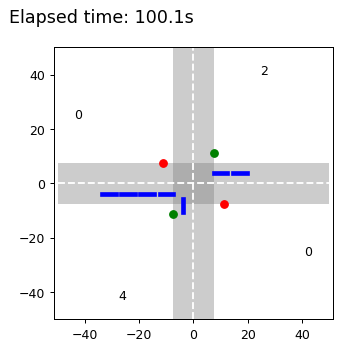

In [5]:
network.simulate(delta_t=0.1, end_time=100, animate=True, fig_width=4, file_name="figs/simulation_1x1.mp4", speed=1)

In [6]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="figs/simulation_1x1.mp4" type="video/mp4">
</video></div>""")

In [7]:
stats = network.get_stats()
print("Average wait time:", stats[(0,0)]["N"]["wait_time"], "s")
print("Average queue length: ", stats[(0,0)]["N"]["avg_queue_length"], "vehicles")

Average wait time: 1.6941176470588244 s
Average queue length:  0.34265734265734266 vehicles


In [8]:
print("Average wait time:", stats[(0,0)]["E"]["wait_time"], "s")
print("Average queue length: ", stats[(0,0)]["E"]["avg_queue_length"], "vehicles")

Average wait time: 1.1500000000000004 s
Average queue length:  0.7342657342657343 vehicles


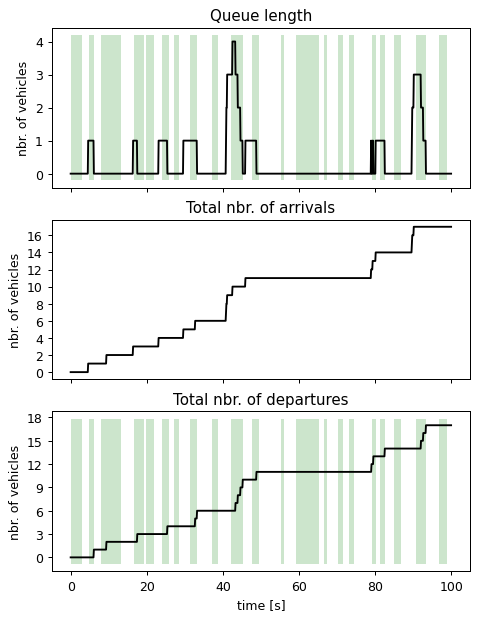

In [9]:
fig, axs = network.plot_queue_stats(plt=plt, grid_ind=(0,0), direction='N', end_time=100, delta_t=0.1, traffic_light=light_ns,fig_size=(6,8))
plt.savefig('figs/eastbound_(0,0)', bbox_inches='tight')

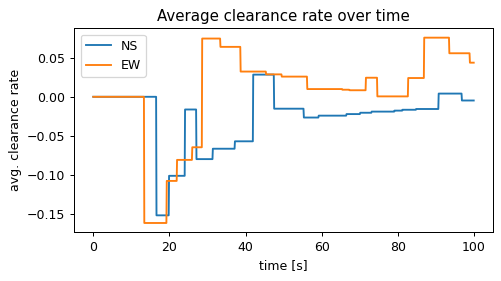

In [10]:
fig, axs = network.plot_avg_clearance_rate(plt=plt, grid_ind=(0,0), end_time=100, delta_t=0.1, fig_size=(6,3))